## 필요한 라이브러리 불러오기

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image, ImageOps
from ultralytics import YOLO
from IPython.display import Video

## 사전 학습된 YOLOv8n 모델 적용

In [2]:
model = YOLO('yolov8n.pt')

print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

기존 COCO 모델은 위 80개 클래스에 대한 패턴 보는 방법만 알고 있다.


image 1/1 D:\project\anomaly detection\train\images\01_PCB__1.jpg: 640x640 3 traffic lights, 2 kites, 14.6ms
Speed: 6.4ms preprocess, 14.6ms inference, 238.6ms postprocess per image at shape (1, 3, 640, 640)


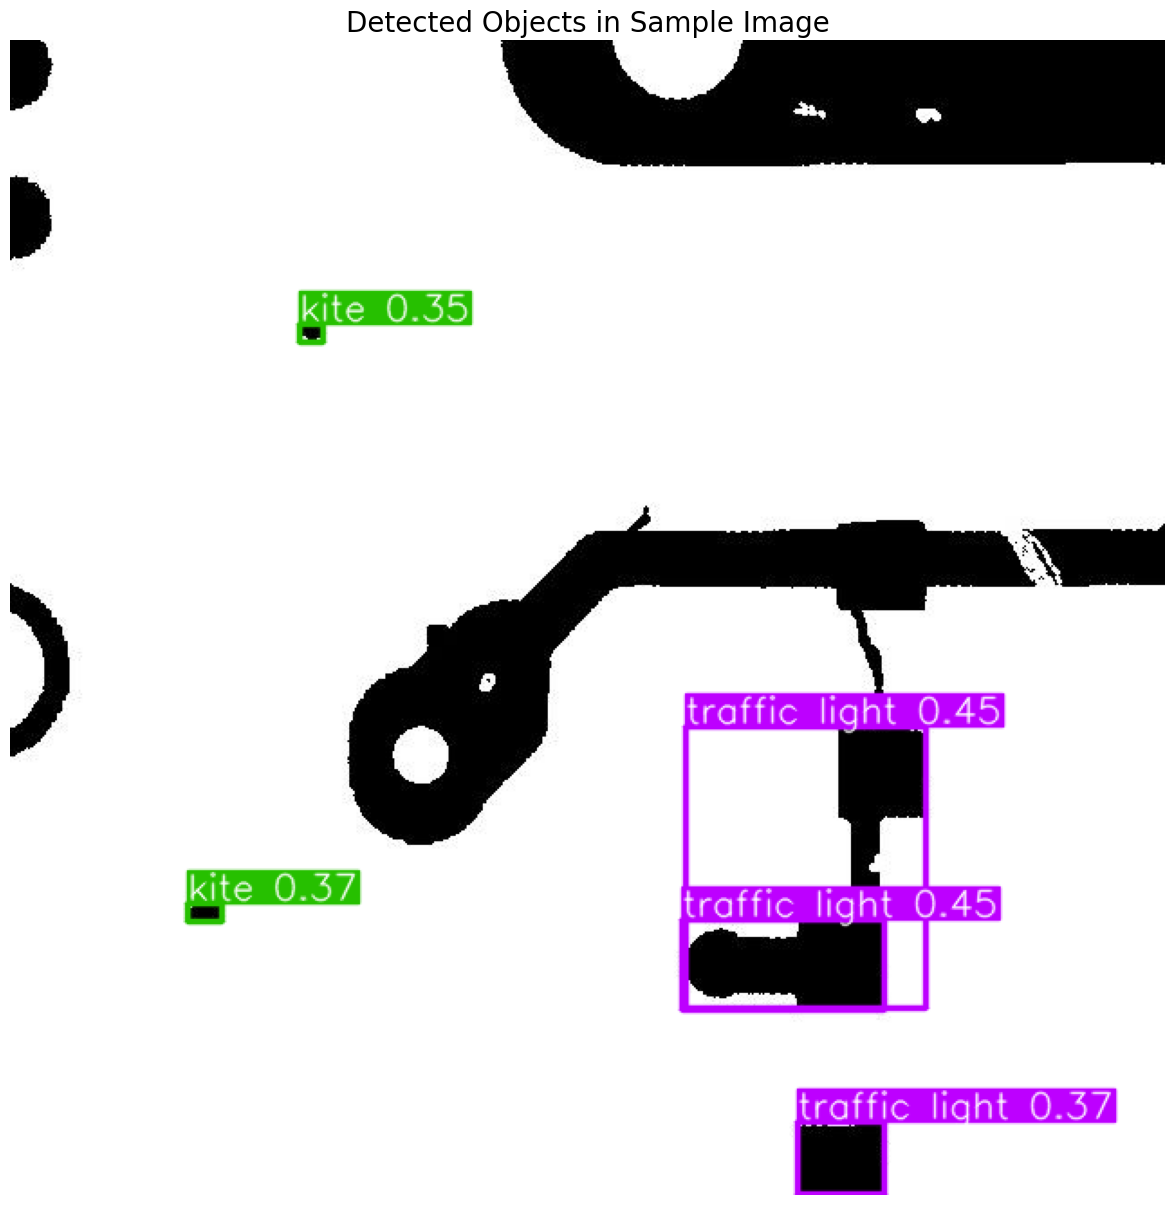

In [3]:
# 이미지 경로
image_path = "D:/project/anomaly detection/train/images/01_PCB__1.jpg"

# 생성된 이미지 추론 // size: 640, 예측치: 0.5 이상만 출력
results = model.predict(source=image_path, imgsz= 640, conf=0.3)

# 이미지 numpy배열로 변환 
sample_image = results[0].plot(line_width=2)

# 이미지 BGR to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.figure(figsize=(20, 15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image', fontsize=20)
plt.axis('off')
plt.show()

 위와 같이 **사전 학습된 COCO 모델로만 예측을 수행한다면**, PCB 결함 이미지의 형태를 일반 사물(kite, trffic light 등)과 같이 **유사한 패턴으로 잘못 인식**하게 된다.

 이에 따라, `data.yaml`파일에 **6개의 결함 클래스**(**missing_hole, mouse_bite, open_circuit, short, spur, spurious_copper**)에 대한 **이미지와 라벨을 제공하여 재학습**(**fine-tuning**)함으로써, 모델이 PCB 결함에 특화된 특징을 학습하고 **정확하게 결함 유형을 예측**할 수 있도록 개선한다.

## 데이터셋 탐색

In [8]:
# 데이터셋 경로
dataset_path = 'D:/project/anomaly detection/'

# YAML 파일 
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# YAML 파일 로드 및 출력
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- missing_hole
- mouse_bite
- open_circuit
- short
- spur
- spurious_copper
nc: 6
test: ../test/images
train: ../train/images
val: ../valid/images



- 이미지 경로만 지정하면 `**형제 폴더**(labels)`도 자동으로 탐색함.
- 이미지에 대한 `**정답**(labels)`이 있기 때문에 학습을 진행할 수 있음.

## 데이터셋 연결

In [5]:
# 훈련용, 검증용 이미지 경로 설정
train_images_path = os.path.join(dataset_path, 'train', 'images')

valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# 이미지 수 카운터 초기화
num_train_images = 0    
num_valid_images = 0

# 중복 제거 해상도 집합 생성 
train_image_sizes = set()   
valid_image_sizes = set()

# 훈련용 이미지 파일들 카운트 및 사이즈 확인
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# 확인용 이미지 파일들 카운트 및 사이즈 확인
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# 이미지 파일 갯수 출력
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# 훈련용 이미지 파일들 같은 사이즈인지 확인
if len(train_image_sizes) == 1:
    print(f"ALL training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# 확인용 이미지 파일들 같은 사이즈인지 확인
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 1200
Number of validation images: 150
ALL training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


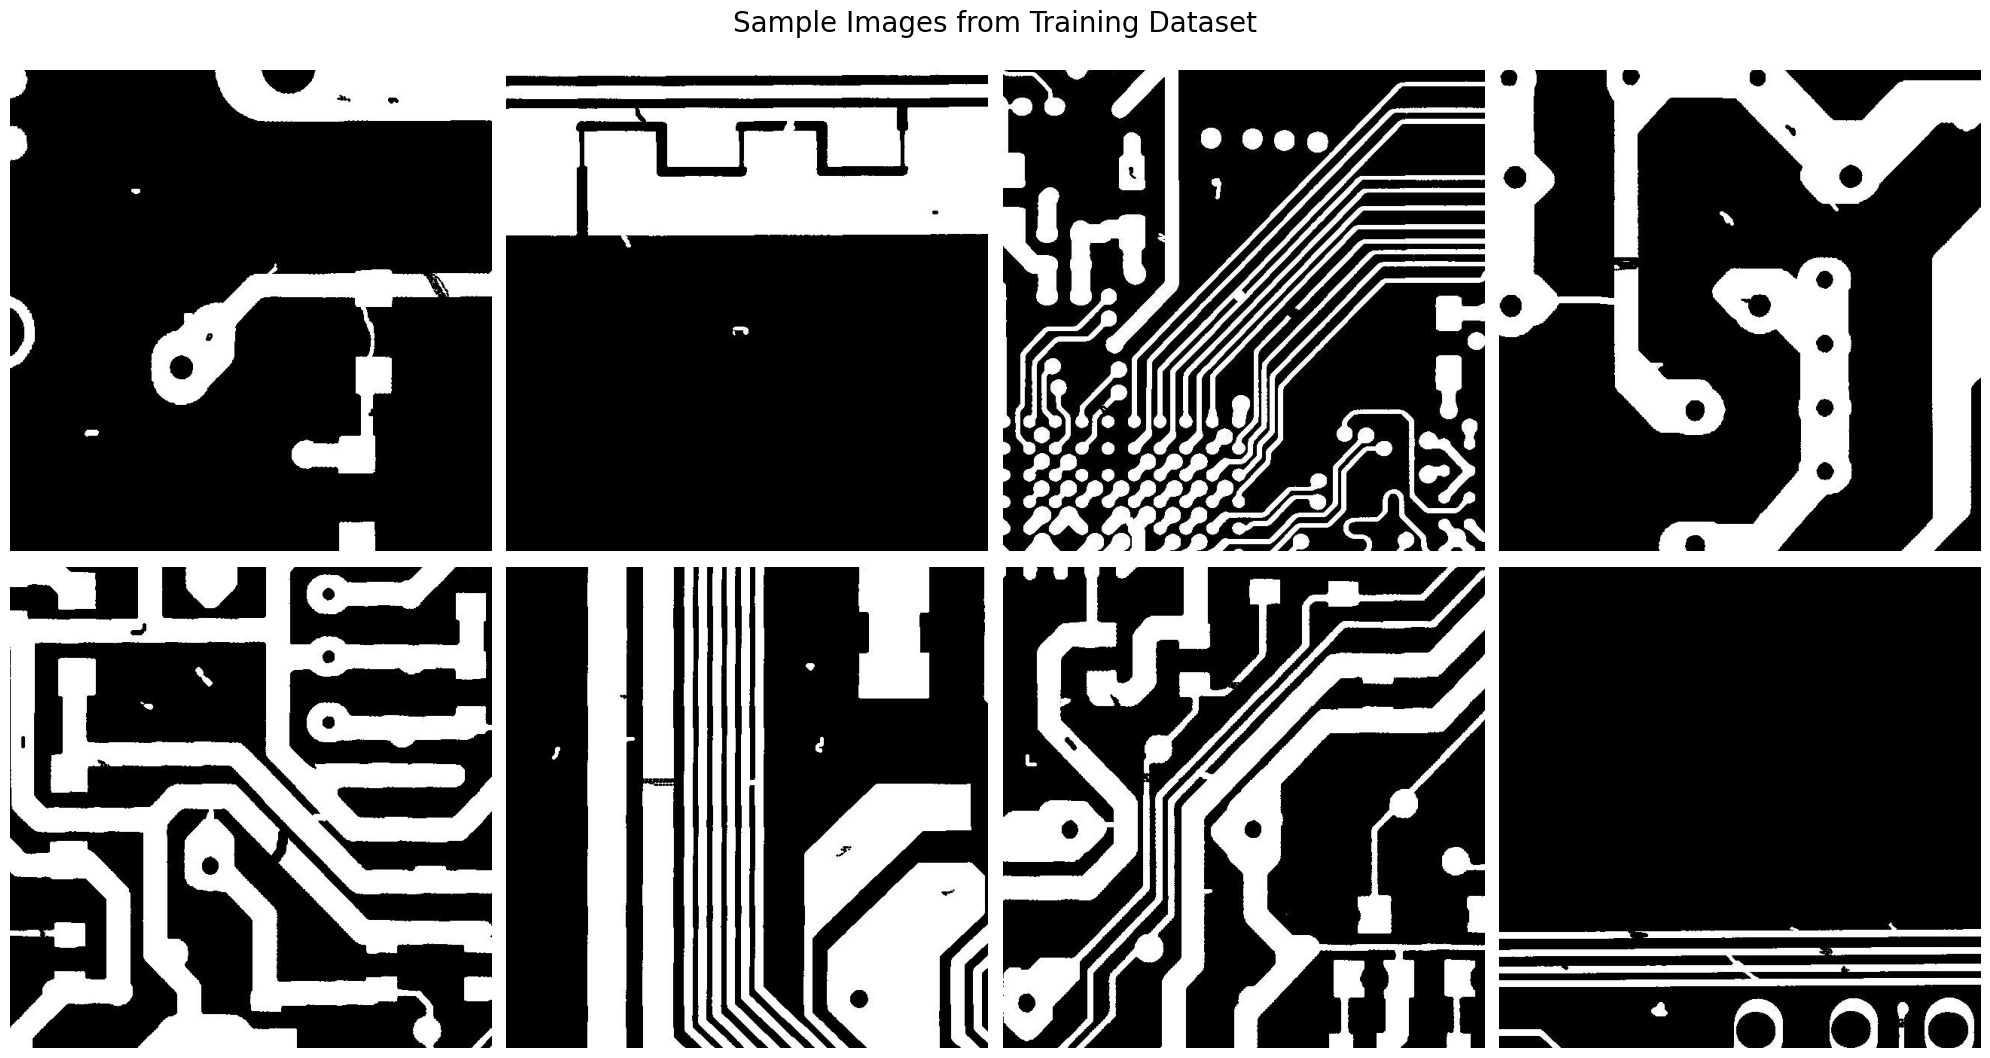

In [6]:
# 경로 속 모든 .jpg파일을 리스트로 가지고 옴
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# 8개 이미지 선택
num_images = len(image_files)    # 1200
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]    # 1200 ÷ 8 = 150 // 150번째마다 이미지 선택
# 2x4 표 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# 시각화
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path).convert("RGB")   # RGB로 변환
    image = ImageOps.invert(image)                # RGB 반전
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
# 맞춤형 데이터셋 모델 훈련
results = model.train(
    data=yaml_file_path,     # 데이터셋
    epochs=100,              # 훈련 횟수
    imgsz=512,               # 이미지 사이즈 
    optimizer='auto',        # 옵티마이저 설정에 맞게 사용
    device=0,                # 쿠다 사용
    patience=30,             # 30 epoch 동안 성능 개선 안되면 학습 종료
    batch=16,                # batch수만큼 한 번에 학습
    workers=2                # 데이터 불러올 때 worker수만큼 프로세스 사용
)

New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.199  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/project/anomaly detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train10, nbs=64,

In [4]:
# NOTE: YOLO 결과 기본 저장 경로 C:\Users\jinhyeongsik\runs\detect\
# 현재 프로젝트 내에서 D:\project\anomaly detection\runs\detect\train 로 이동

# 학습된 결과 경로 설정
post_training_files_path = 'D:/project/anomaly detection/runs/detect/train'

# 파일 확인
os.listdir(post_training_files_path)

['args.yaml',
 'BoxF1_curve.png',
 'BoxPR_curve.png',
 'BoxP_curve.png',
 'BoxR_curve.png',
 'confusion_matrix.png',
 'confusion_matrix_normalized.png',
 'labels.jpg',
 'results.csv',
 'results.png',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'train_batch6750.jpg',
 'train_batch6751.jpg',
 'train_batch6752.jpg',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'weights']

## 손실값 그래프

In [8]:
# 손실 값에 대한 학습 곡선 함수
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', 
                 color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss',
                 color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


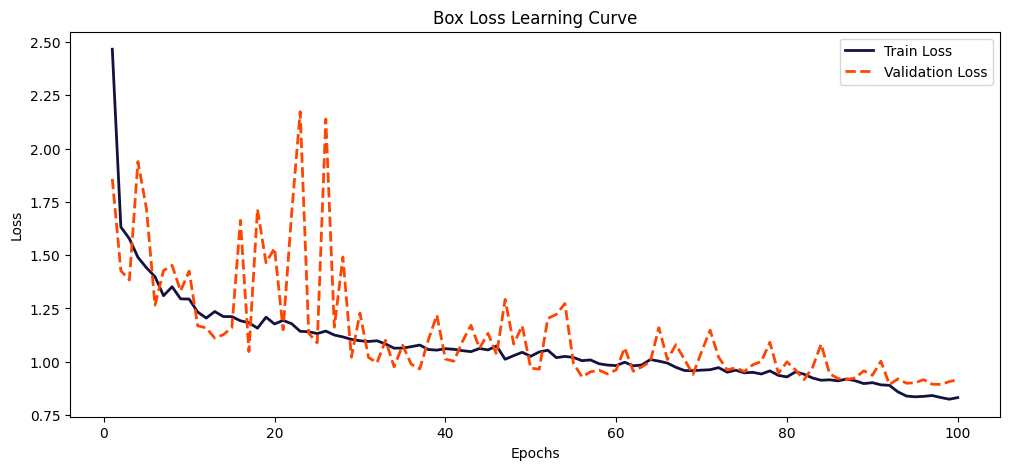

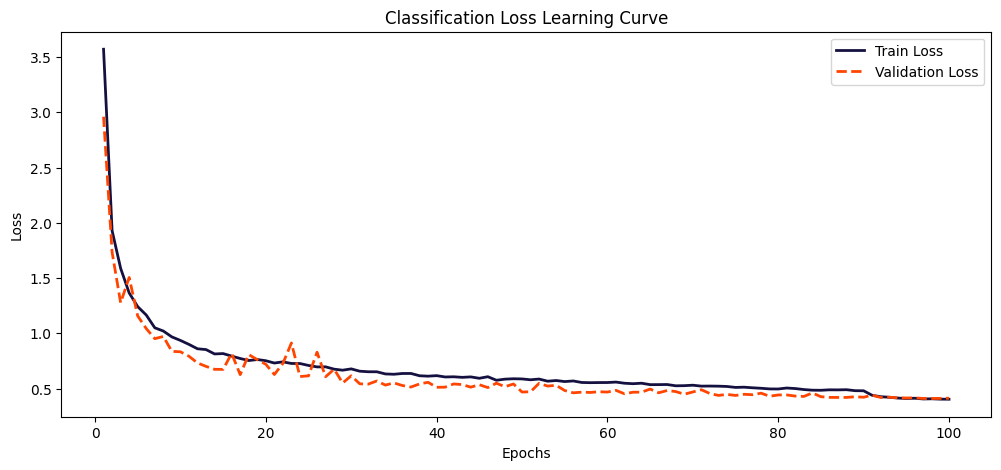

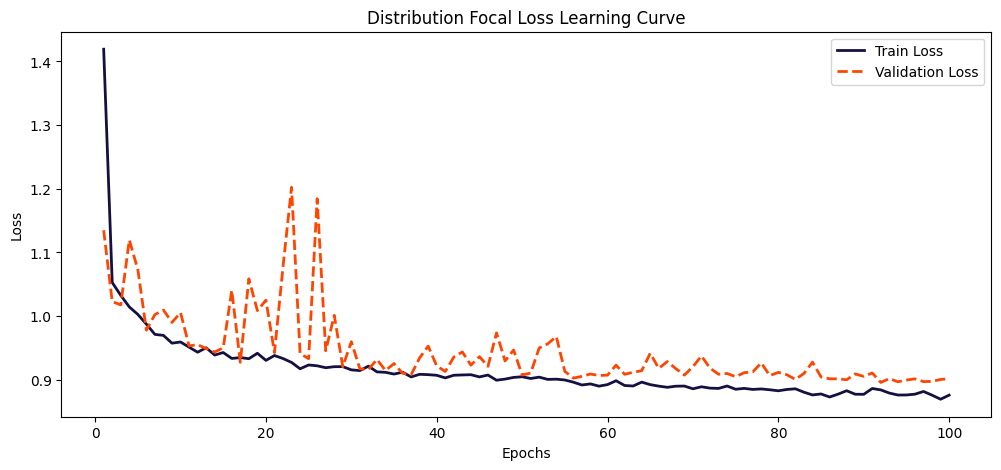

In [9]:
# csv파일 경로 설정
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# PandasDataframe으로 results_csv_path 연결
df = pd.read_csv(results_csv_path)

# 컬럼의 공백(띄어쓰기) 제거
df.columns = df.columns.str.strip()

print(df.columns)

# 학습률 그래프
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

## 모델 학습 곡선 분석
- **`Box Loss`**
    - 초반 급격히 하락 → 모델이 빠르게 위치 감을 잡음.
    - 이후 안정화 → 과적합 없이 꾸준히 수렴함.
    - Validation loss는 진동하지만 점점 안정된 학습을 진행함.

- **`Classification Loss`**
    - 초반 급격히 하락 → 모델이 결함 유형을 빠르게 구분함
    - 이후 Train/Val 모두 거의 일치 → 과적합 없음.

- **`Distribution Focal Loss`**
    - 초반 급격히 하락 → 좌표 예측의 정밀도 향상함.
    - 이후 진동하지만 점점 안정된 학습을 진행함.

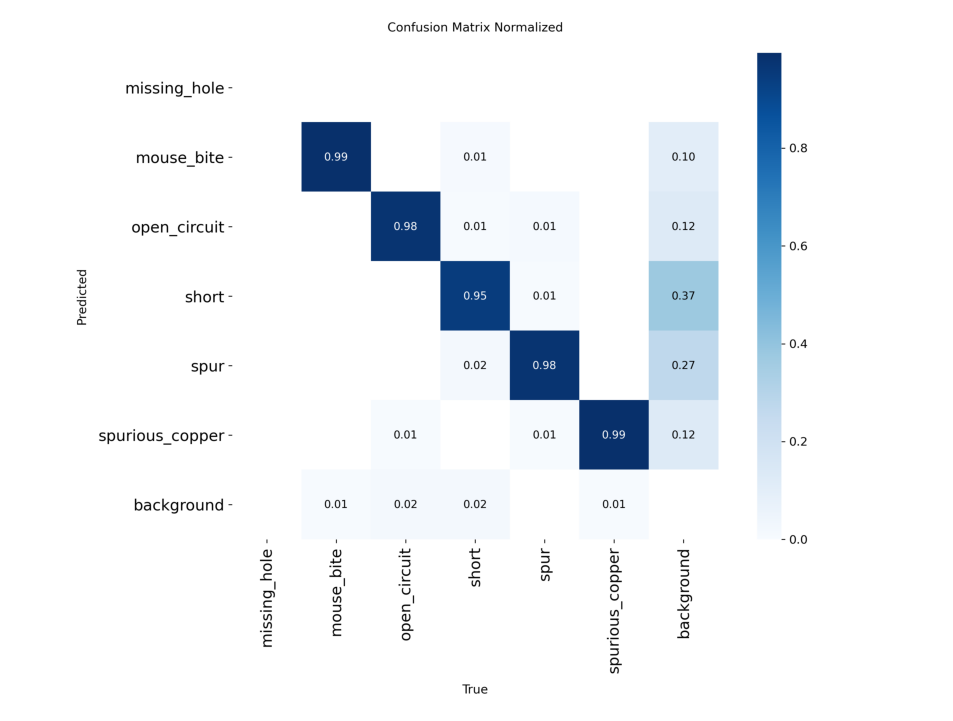

In [10]:
# 정규화 이미지 경로
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# 이미지 읽기
cm_img = cv2.imread(confusion_matrix_path)

# BGR to RGB
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

## 행렬 분석
- 전반적으로 0.95~0.99으로 모델이 대부분의 결함을 정확히 구분함.
- background 영역에선 오탐이 조금 있음.

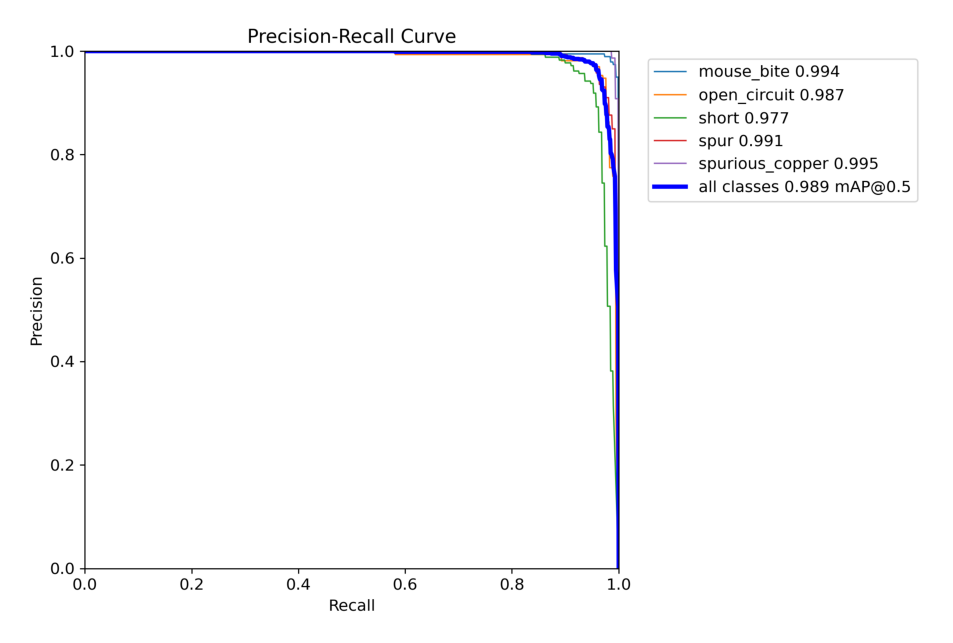

In [11]:
# 정밀도, 재현율 경로
BoxPR_path = os.path.join(post_training_files_path, 'BoxPR_curve.png')

# 이미지 읽기
PR_img = cv2.imread(BoxPR_path)

# BGR to RGB
PR_img = cv2.cvtColor(PR_img, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(PR_img)
plt.axis('off')
plt.show()

## BoxPR Curve(종합 탐지 성능) 해석
- 모든 곡선이 (1.0, 1.0)에 근접함. Precision과 Recall이 동시에 높음.
- 모델이 거의 완벽하게 일반화됨.

## 가장 성능 좋은 모델 학습

In [52]:
# 100회중 가장 성능이 좋던 모델의 경로
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# 가장 성능 좋은 모델 학습
best_model =YOLO(best_model_path)

## 모델 추론 및 평가

In [53]:
valid_images_path = r"D:/project/anomaly detection/valid/images"
# 이 폴더로 저장됨: D:/project/anomaly detection/results/
pred = best_model.predict(
    source=valid_images_path,
    imgsz=640,
    conf=0.5,
    save=True,                                  # ※ 결과 이미지 자동 저장
    project=r"D:/project/anomaly detection/best",    # 상위 폴더
    name="results",                              # 하위 폴더명
    verbose=False
)

# validation 실행 → 각종 리포트/플롯 저장
metrics = best_model.val(
    data=yaml_file_path,                         # DeepPCB data.yaml
    imgsz=640,
    conf=0.5,
    iou=0.5,
    project=r"D:/project/anomaly detection/best",
    name="val",                           # 저장 폴더: .../val_report/
    plots=True                                   # confusion_matrix.png, PR 곡선 등 저장
)

print("mAP50:", float(metrics.box.map50))
print("mAP50-95:", float(metrics.box.map))

Results saved to D:\project\anomaly detection\best\results
Ultralytics 8.3.199  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 190.361.8 MB/s, size: 37.3 KB)
val: Scanning D:\project\anomaly detection\valid\labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 75.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.9it/s 11.4s.3s
                   all        150        858      0.958       0.92      0.956      0.547
            mouse_bite        138        189      0.961      0.952      0.956      0.548
          open_circuit        117        167      0.974      0.885      0.958      0.549
                 short        126        189      0.959      0.884      0.937      0.479
                  spur        119        165      0.915      0.915      0.946      0.517
       spurious_copper        125        148  

전체적으로 **정확도**(**Precision**)는 매우 높고, **재현율**(**Recall**)은 약간 낮다.     
→ 즉, **“잘못 탐지**(**False Positive**)”는 거의 없지만, “**놓치는 경우**(**False Negative**)”가 일부 존재합니다.

In [54]:
# 정규화 이미지 경로
confusion_matrix_path = os.path.join('D:/project/anomaly detection/best/val/confusion_matrix_normalized.png')

# 이미지 읽기
cm_img = cv2.imread(confusion_matrix_path)

# BGR to RGB
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

<Figure size 1200x1200 with 1 Axes>

`background`열에서 다른 클래스 행으로 예측된 부분이 많다.  
→ 즉, **실제로 결함이 있는데 background로 놓친 경우**(**False Negative**)가 꽤 존재함.  
→ 이는 **Recall**(**재현율**)이 낮은 이유와 직결됨.  
- 특히 `short`와 `spur`클래스가 가장 취약함
- 결함이 있는데도 `background`로 판단

### 🔧 Step: Class-specific Resampling for Fine-tuning
모델이 **short**와 **spur** 결함을 `background`로 잘못 분류하는 현상을 개선하기 위해  
해당 클래스의 이미지와 라벨을 **리샘플링(resampling)** 합니다.  

아래 스크립트(`short_spur_copy.py`)는  
train 데이터 중 short, spur가 2개 이상 포함된 샘플만 선별하여  
`Fine_tuning` 폴더로 복사합니다.

### 📂 Step: Prepare Fine-tuning Dataset
- `train/images` 및 `train/labels` 폴더를 복사하여  
  `Fine_tuning/images`, `Fine_tuning/labels` 폴더에 붙여넣음.
- 이후 `short_spur_copy.py` 스크립트를 실행하여  
  short(3), spur(4) 클래스가 각각 2개 이상 포함된 샘플만 선별.
- 이 데이터셋을 기반으로 fine-tuning을 진행.

In [47]:
!python "D:/project/anomaly detection/short_spur_copy.py"

01_PCB__1006_copy.jpg  → short:3, spur:2
01_PCB__1022_copy.jpg  → short:2, spur:2
01_PCB__1023_copy.jpg  → short:2, spur:2
01_PCB__1034_copy.jpg  → short:2, spur:2
01_PCB__1041_copy.jpg  → short:2, spur:2
01_PCB__1061_copy.jpg  → short:2, spur:2
01_PCB__1064_copy.jpg  → short:2, spur:2
01_PCB__1072_copy.jpg  → short:2, spur:2
01_PCB__1095_copy.jpg  → short:2, spur:2
01_PCB__110_copy.jpg  → short:3, spur:3
01_PCB__1102_copy.jpg  → short:2, spur:2
01_PCB__117_copy.jpg  → short:2, spur:2
01_PCB__1216_copy.jpg  → short:2, spur:2
01_PCB__127_copy.jpg  → short:4, spur:3
01_PCB__131_copy.jpg  → short:3, spur:2
01_PCB__1312_copy.jpg  → short:3, spur:2
01_PCB__1384_copy.jpg  → short:3, spur:2
01_PCB__1409_copy.jpg  → short:2, spur:2
01_PCB__146_copy.jpg  → short:2, spur:2
01_PCB__147_copy.jpg  → short:4, spur:2
01_PCB__148_copy.jpg  → short:4, spur:2
01_PCB__1498_copy.jpg  → short:2, spur:2
01_PCB__157_copy.jpg  → short:3, spur:2
01_PCB__162_copy.jpg  → short:2, spur:2
01_PCB__165_copy.jpg  → s

##  Fine_tuning 데이터셋 탐색 및 모델 훈련

In [42]:
model = YOLO(r"D:/project/anomaly detection/runs/detect/train/weights/best.pt")

# YAML 파일 
Fine_tuning_yaml_file_path = os.path.join(dataset_path, 'Fine_tuning.yaml')

# YAML 파일 로드 및 출력
with open(Fine_tuning_yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- missing_hole
- mouse_bite
- open_circuit
- short
- spur
- spurious_copper
nc: 6
test: ../test/images
train: ../Fine_tuning/images
val: ../valid/images



In [11]:
# 모델 훈련
model.train(
    data=Fine_tuning_yaml_file_path,     # 기존 데이터셋 + short_spur 특화된 데이터
    epochs=20,                           # 훈련 횟수
    imgsz=512,                           # 이미지 사이즈 
    optimizer='auto',                    # 옵티마이저 설정에 맞게 사용
    device=0,                            # 쿠다 사용
    freeze=10,                           # COCO에서 학습된 백본 그대로 두고, short·spur 클래스 새 데이터만 Fine-tuning
    patience=10,                         # 10 epoch 동안 성능 개선 안되면 학습 종료
    batch=16,                            # batch수만큼 한 번에 학습
    workers=2                            # 데이터 불러올 때 worker수만큼 프로세스 사용
)

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.199  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/project/anomaly detection/Fine_tuning.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=D:/project/anomaly detection/runs/detect/train/weights/best.pt, momentum=0.9

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000179AE17ACB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

📖 `freeze` 참고 문서: [Ultralytics Train Mode 공식 문서](https://docs.ultralytics.com/ko/modes/train/#resuming-interrupted-trainings)

In [51]:
# NOTE: YOLO 결과 기본 저장 경로 C:\Users\jinhyeongsik\runs\detect\
# 현재 프로젝트 내에서 D:\project\anomaly detection\runs\detect\Fine_tuning_train 로 이동

# 학습된 결과 경로 설정
post_Fine_tuning_training_files_path = 'D:/project/anomaly detection/runs/detect/Fine_tuning_train'

# 파일 확인
os.listdir(post_Fine_tuning_training_files_path)

# 20회중 가장 성능이 좋던 모델의 경로
best_model_path = os.path.join(post_Fine_tuning_training_files_path, 'weights/best.pt')

# 가장 성능 좋은 모델 학습
best_model =YOLO(best_model_path)

valid_images_path = r"D:/project/anomaly detection/valid/images"
# 이 폴더로 저장됨: D:/project/anomaly detection/results/
pred = best_model.predict(
    source=valid_images_path,
    imgsz=640,
    conf=0.5,
    save=True,                                  # ※ 결과 이미지 자동 저장
    project=r"D:/project/anomaly detection/best",    # 상위 폴더
    name="tuning results",                              # 하위 폴더명
    verbose=False
)

# validation 실행 → 각종 리포트/플롯 저장
metrics = best_model.val(
    data=Fine_tuning_yaml_file_path,                         # DeepPCB data.yaml
    imgsz=640,
    conf=0.5,
    iou=0.5,
    project=r"D:/project/anomaly detection/best",
    name="tuning val",                           # 저장 폴더: .../val_report/
    plots=True                                   # confusion_matrix.png, PR 곡선 등 저장
)

print("mAP50:", float(metrics.box.map50))
print("mAP50-95:", float(metrics.box.map))

# 정규화 이미지 경로
confusion_matrix_path = os.path.join('D:/project/anomaly detection/best/tuning val/confusion_matrix_normalized.png')

# 이미지 읽기
cm_img = cv2.imread(confusion_matrix_path)

# BGR to RGB
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

Results saved to D:\project\anomaly detection\best\tuning results
Ultralytics 8.3.199  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 116.543.6 MB/s, size: 27.7 KB)
val: Scanning D:\project\anomaly detection\valid\labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 148.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 1.4it/s 7.1s.3ss
                   all        150        858      0.928      0.891      0.933      0.425
            mouse_bite        138        189      0.951      0.925       0.94       0.44
          open_circuit        117        167      0.959      0.833      0.931      0.434
                 short        126        189      0.894      0.844      0.895      0.348
                  spur        119        165      0.866      0.897      0.925      0.383
       spurious_copper        125     

<Figure size 1200x1200 with 1 Axes>